In [53]:
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from gaussian_process import Multifidelity_GP
from gaussian_process import GP
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl

%matplotlib notebook
np.random.seed(1234)

In [2]:
def f_H(x):
    #1-D
    #optimum at x=0.96609, f(x)=-1.48907
    return -(1.4-3*x)*np.sin(18*x)

def f_L(x):
    return 0.5*f_H(x) + 2.0*(x-0.5) - 1.0

def Normalize(X, X_m, X_s):
    return (X-X_m)/(X_s)

In [3]:
N_H = 10
N_L = 20
D = 1
lb = 0.0*np.ones(D)
ub = 1.2*np.ones(D)
noise_L = 0.1
noise_H = 0.1

Normalize_input_data = 1
Normalize_output_data = 1

<IPython.core.display.Javascript object>


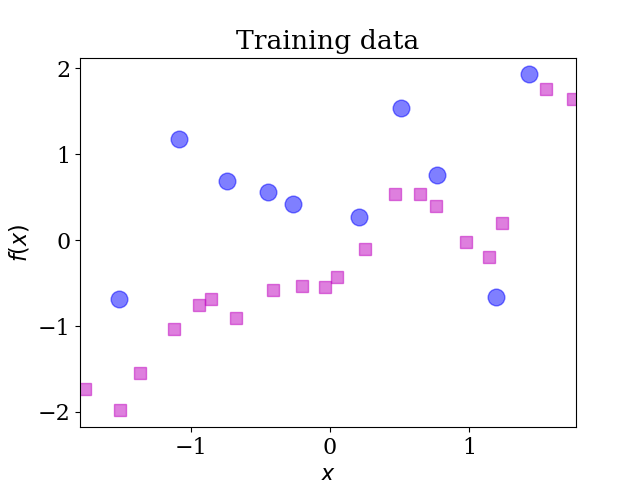

Text(0, 0.5, '$f(x)$')

In [4]:
# Training data
X_L = lb + (ub-lb)*lhs(D, N_L)
y_L = f_L(X_L) + noise_L*np.random.randn(N_L,D)

X_H = lb + (ub-lb)*lhs(D, N_H)
y_H = f_H(X_H) + noise_H*np.random.randn(N_H,D)

# Test data
nn = 200
X_star = np.linspace(lb, ub, nn)
y_star = f_H(X_star)

 #  Normalize Input Data
if Normalize_input_data == 1:
    X = np.vstack((X_L,X_H))
    X_m = np.mean(X, axis = 0)
    X_s = np.std(X, axis = 0)   
    X_L = Normalize(X_L, X_m, X_s)
    X_H = Normalize(X_H, X_m, X_s)
    lb = Normalize(lb, X_m, X_s)
    ub = Normalize(ub, X_m, X_s)
    X_star = Normalize(X_star, X_m, X_s)

#  Normalize Output Data
if Normalize_output_data == 1:
    y = np.vstack((y_L,y_H))
    y_m = np.mean(y, axis = 0)
    y_s = np.std(y, axis = 0)   
    y_L = Normalize(y_L, y_m, y_s)
    y_H = Normalize(y_H, y_m, y_s)
    y_star = Normalize(y_star, y_m, y_s)
    
# Plot the training data
plt.figure(facecolor='w')
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=16)
plt.plot(X_H,y_H,'bo', markersize = 12, alpha = 0.5, label = "Data")
plt.plot(X_L,y_L,'ms', markersize = 8, alpha = 0.5, label = "Data")
plt.title("Training data")
ax = plt.gca()
ax.set_xlim([lb[0], ub[0]])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

In [5]:
# Define model
model = Multifidelity_GP(X_L, y_L, X_H, y_H)

Total number of parameters: 7


In [6]:
# Train 
model.train()

In [7]:
gp_model = GP(X_H, y_H)
gp_model.train()
gp_y_pred, gp_y_var = gp_model.predict(X_star)
gp_y_var = np.abs(np.diag(gp_y_var))

Total number of parameters: 3
Log likelihood 41.605467640596856
Log likelihood 15.706652195043592
Log likelihood 14.948384167421748
Log likelihood 14.61242092231295
Log likelihood 14.418202774917347
Log likelihood 14.194453447532553
Log likelihood 14.13150322632256
Log likelihood 14.123694981997222
Log likelihood 14.123503729218198
Log likelihood 14.12335577225909
Log likelihood 14.12335335452455
Log likelihood 14.123348583418045
Log likelihood 14.1233275705425
Log likelihood 14.12328142691694
Log likelihood 14.12316934899506
Log likelihood 14.12296061007085
Log likelihood 14.122613632491094
Log likelihood 14.12199938547936
Log likelihood 14.121979622912331
Log likelihood 14.121227316920116
Log likelihood 14.120819094142357
Log likelihood 14.120564623565244
Log likelihood 14.120381645061787
Log likelihood 14.12028896387943
Log likelihood 14.120212139281646
Log likelihood 14.120184033269492
Log likelihood 14.120169728714421
Log likelihood 14.120161423485671
Log likelihood 14.12015683697

Relative L2 error u: 0.21869898416789804
Relative L2 error u: 0.4848801682051456


<IPython.core.display.Javascript object>


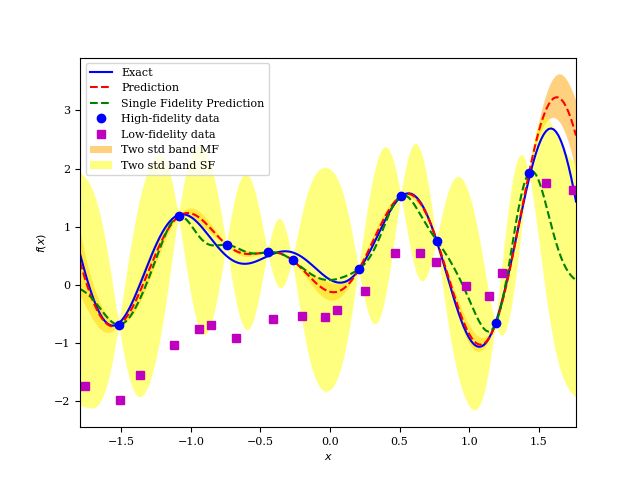

Text(0, 0.5, '$f(x)$')

In [8]:
# Predict
y_pred, y_var = model.predict(X_star)
y_var = np.abs(np.diag(y_var))

# Check accuracy                       
error = np.linalg.norm(y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")
error = np.linalg.norm(gp_y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")

# Plot
plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=8)
plt.plot(X_star, y_star, 'b-', label = "Exact")
plt.plot(X_star, y_pred, 'r--', label = "Prediction")
plt.plot(X_star, gp_y_pred, 'g--', label = "Single Fidelity Prediction")
lower = y_pred - 2.0*np.sqrt(y_var[:,None])
upper = y_pred + 2.0*np.sqrt(y_var[:,None])
plt.fill_between(X_star.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band MF")
gp_lower = gp_y_pred - 2.0*np.sqrt(gp_y_var[:,None])
gp_upper = gp_y_pred + 2.0*np.sqrt(gp_y_var[:,None])
plt.fill_between(X_star.flatten(), gp_lower.flatten(), gp_upper.flatten(), 
                 facecolor='yellow', alpha=0.5, label="Two std band SF")
plt.plot(X_H,y_H,'bo', label = "High-fidelity data")
plt.plot(X_L,y_L,'ms', label = "Low-fidelity data")
plt.legend()
ax = plt.gca()
ax.set_xlim([lb[0], ub[0]])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

In [9]:
print(y_star[y_pred==y_pred.min()]--1.48907)

[0.42960311]


In [10]:
def booth(X):
    #2-D
    #optimum at X=[1,3] f(X)=0
    X = np.atleast_2d(X)
    x = X[:, 0]
    y = X[:, 1]
    return((x+2*y-7)**2+(2*x+y-5)**2)

In [11]:
def booth_l(X):
    X = np.atleast_2d(X)
    return(0.23 * booth(X)+X[:,0]+X[:,1]**2+6)

In [33]:
N_H = 10
N_L = 25
D = 2
lb = -5.0
ub = 5.0
noise_L = 1.0
noise_H = 1.0

[[884.         871.12172227 858.34547495 ... 153.69901031 158.79848995
  164.        ]]


<IPython.core.display.Javascript object>


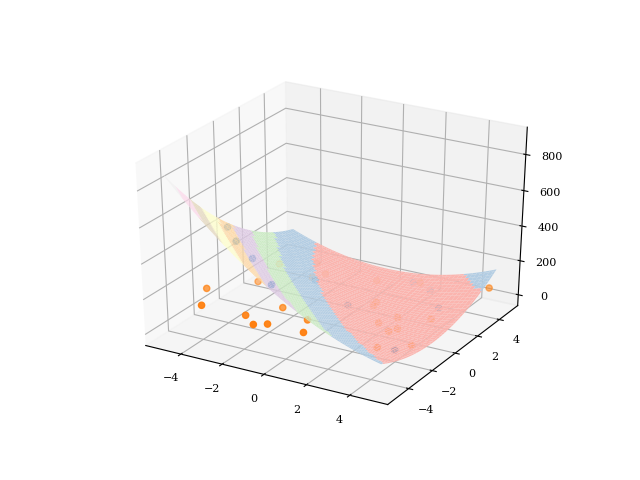

In [47]:
# Training data    
X_L = lb + (ub-lb)*lhs(D, N_L)
y_L = booth_l(X_L)
y_L = np.atleast_2d(y_L).T

X_H = lb + (ub-lb)*lhs(D, N_H)
y_H = booth(X_H)
y_H = np.atleast_2d(y_H).T

# Test data
nn = 100
x_star = np.linspace(lb, ub, nn)
xx, yy = np.meshgrid(x_star, x_star)

X_star = []
for i in x_star:
    for n in x_star:
        X_star.append([i,n])
X_star = np.array(X_star)
y_star_temp = np.array([booth(X_star)])
print(y_star_temp)
y_star = y_star_temp.reshape(nn,nn)

# Plot the training data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_H[:,0], X_H[:,1], y_H, label="hf")
ax.scatter(X_L[:,0],X_L[:,1], y_L, label="lf")
ax.plot_surface(xx, yy, y_star, cmap=cm.Pastel1)
plt.show()

In [41]:
# Define model
model = Multifidelity_GP(X_L, y_L, X_H, y_H)
model.jitter = 1e-2

Total number of parameters: 9


In [42]:
# Train 
model.train()

In [29]:
print(X_star)

[[-5.        -5.       ]
 [-5.        -4.8989899]
 [-5.        -4.7979798]
 ...
 [ 5.         4.7979798]
 [ 5.         4.8989899]
 [ 5.         5.       ]]


In [43]:
print(model.hyp)

[ 19.61835329   4.99234357   4.66803158  16.04200491   6.87880794
   3.44172158   4.34531336 -17.34366716 -15.87213238]


In [44]:
# Predict
y_pred, y_var = model.predict(X_star)

In [45]:
gp_model = GP(X_H, y_H)
gp_model.train()
gp_y_pred, gp_y_var = gp_model.predict(X_star)
gp_y_var = np.abs(np.diag(gp_y_var))

Total number of parameters: 4
Log likelihood 85385.34608409238
Log likelihood 46074.597619154905
Log likelihood 20464.422777517677
Log likelihood 10282.234707242511
Log likelihood 5693.158948806998
Log likelihood 2866.399945423602
Log likelihood 1458.6074067069276
Log likelihood 747.1548482671589
Log likelihood 394.2500760020107
Log likelihood 219.36011141545816
Log likelihood 133.68663000024685
Log likelihood 93.18054745829305
Log likelihood 74.52964191597641
Log likelihood 66.59126416050472
Log likelihood 63.175277388059584
Log likelihood 61.680381059239394
Log likelihood 61.15188732986167
Log likelihood 60.972098407318796
Log likelihood 60.93203126160705
Log likelihood 60.91218775194566
Log likelihood 60.90414712529943
Log likelihood 60.902652618644034
Log likelihood 60.902646736300156
Log likelihood 60.90264654535698
Log likelihood 60.90264654275768


In [50]:
gp_y_pred = gp_y_pred.T.reshape(nn,nn)
error = np.linalg.norm(gp_y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")

Relative L2 error u: 0.5120680146850426


In [49]:
y_var = np.abs(np.diag(y_var))
y_pred = y_pred.T.reshape(nn,nn)
# Check accuracy                       
error = np.linalg.norm(y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")

Relative L2 error u: 0.0007202346336918987


<IPython.core.display.Javascript object>


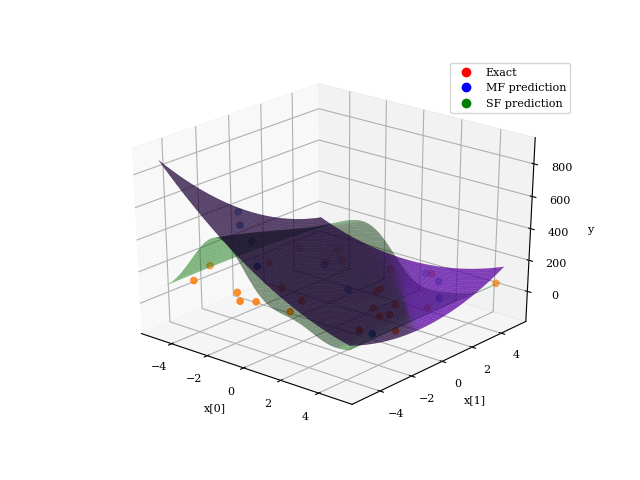

In [59]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_H[:,0], X_H[:,1], y_H, label="HF")
ax.scatter(X_L[:,0],X_L[:,1], y_L, label="LF")

ax.plot_surface(xx, yy, y_star, label = "Exact", color = "r", alpha=0.5)
ax.plot_surface(xx, yy, y_pred, label = "Prediction", color = "b",alpha=0.5)
ax.plot_surface(xx, yy, gp_y_pred, label = "Prediction", color = "g",alpha=0.5)
#ax.plot_surface(xx,yy,y_var.T.reshape(nn,nn), label="Var", alpha=0.25)
mf = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
true = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
gp = mpl.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
ax.legend([true, mf, gp], ['Exact','MF prediction','SF prediction'], numpoints = 1)
ax.set_zlabel('y')
ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
plt.show()


In [60]:
def rastrigin(X):
    #n-D
    #optimum at X=[0,...,0], f(X)=0
    X = np.atleast_2d(X)
    return(10*len(X[0])+np.sum(np.power(X,2)-10*np.cos(2*np.pi*X),1))

In [61]:
def rastrigin_l(X):
    X = np.atleast_2d(X)
    return(0.8 * rastrigin(X)+X[:,0]**2+X[:,1]**2)

In [70]:
N_H = 100
N_L = 200
D = 2
lb = -5.12
ub = 5.12
noise_L = 0.0
noise_H = 0.0

[[57.84942745 54.14476436 54.51651279 ... 54.51651279 54.14476436
  57.84942745]]


<IPython.core.display.Javascript object>


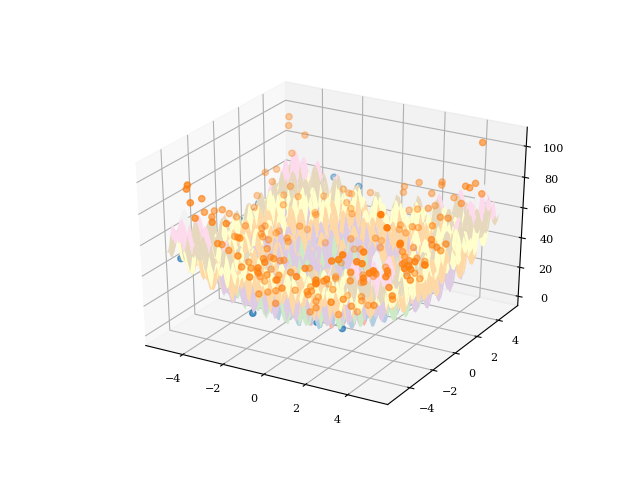

In [71]:
# Training data    
X_L = lb + (ub-lb)*lhs(D, N_L)
y_L = rastrigin_l(X_L)
y_L = np.atleast_2d(y_L).T

X_H = lb + (ub-lb)*lhs(D, N_H)
y_H = rastrigin(X_H)
y_H = np.atleast_2d(y_H).T

# Test data
nn = 100
x_star = np.linspace(lb, ub, nn)
xx, yy = np.meshgrid(x_star, x_star)

X_star = []
for i in x_star:
    for n in x_star:
        X_star.append([i,n])
X_star = np.array(X_star)
y_star_temp = np.array([rastrigin(X_star)])
print(y_star_temp)
y_star = y_star_temp.reshape(nn,nn)

# Plot the training data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_H[:,0], X_H[:,1], y_H)
ax.scatter(X_L[:,0],X_L[:,1], y_L)
ax.plot_surface(xx, yy, y_star, cmap=cm.Pastel1)
plt.show()

In [72]:
# Define model
model = Multifidelity_GP(X_L, y_L, X_H, y_H)

Total number of parameters: 9


In [73]:
# Train 
model.train()

/opt/anaconda3/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in power
  return f_raw(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in true_divide
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


In [74]:
# Predict
y_pred, y_var = model.predict(X_star)

In [75]:
print(y_star_temp.T[y_pred==y_pred.min()])

[17.74735013]


In [76]:
y_var = np.abs(np.diag(y_var))
y_pred = y_pred.T.reshape(nn,nn)
# Check accuracy                       
error = np.linalg.norm(y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")

Relative L2 error u: 0.18301696614807436


In [77]:
gp_model = GP(X_H, y_H)
gp_model.train()
gp_y_pred, gp_y_var = gp_model.predict(X_star)
gp_y_var = np.abs(np.diag(gp_y_var))
gp_y_pred = gp_y_pred.T.reshape(nn,nn)
error = np.linalg.norm(gp_y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")

Total number of parameters: 4
Log likelihood 37460.26240802088
Log likelihood 25655.911125298033
Log likelihood 11105.346262297642
Log likelihood 5929.482349965131
Log likelihood 3047.2345141017186
Log likelihood 1695.4019372668718
Log likelihood 1025.1284135828816
Log likelihood 708.2017001467286
Log likelihood 563.0317898416637
Log likelihood 500.91665862795725
Log likelihood 474.9029096892142
Log likelihood 454.9395625120985
Log likelihood 449.276206394152
Log likelihood 449.1950137385971
Log likelihood 449.19289737134426
Log likelihood 449.1879833029459
Log likelihood 449.18662366185396
Log likelihood 449.1806808882937
Log likelihood 449.17324680692565
Log likelihood 449.1399511910893
Log likelihood 446.5705321066753
Log likelihood 446.5672848222568
Log likelihood 443.07207548005573
Log likelihood 431.88620186807213
Log likelihood 426.5392885992153
Log likelihood 418.8992820623193
Log likelihood 418.41125228279344
Log likelihood 416.9409299630588
Log likelihood 416.1484093890146
Lo

<IPython.core.display.Javascript object>


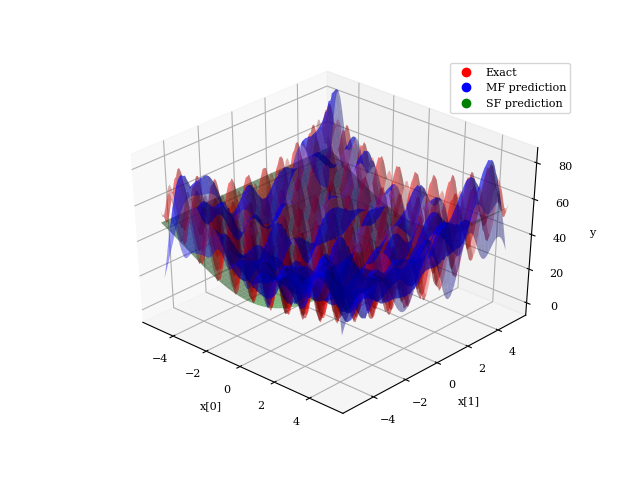

In [81]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(xx, yy, y_star, label = "Exact", color = "r", alpha=0.3)
ax.plot_surface(xx, yy, y_pred, label = "Prediction", color = "b",alpha=0.4)
ax.plot_surface(xx, yy, gp_y_pred, label = "Prediction", color = "g",alpha=0.5)
#ax.plot_surface(xx,yy,y_var.T.reshape(nn,nn), label="Var", alpha=0.25)
mf = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
true = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
gp = mpl.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
ax.legend([true, mf, gp], ['Exact','MF prediction','SF prediction'], numpoints = 1)
ax.set_zlabel('y')
ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
plt.show()

In [30]:
print(np.argsort((y_pred+y_var.T.reshape(nn,nn)).flatten()))
print(X_star[np.argsort((y_pred+y_var.T.reshape(nn,nn)).flatten())])

[3146 3147 1843 ... 9405 9205 9305]
[[-1.91353535 -0.3620202 ]
 [-1.91353535 -0.25858586]
 [-3.25818182 -0.67232323]
 ...
 [ 4.60282828 -4.60282828]
 [ 4.3959596  -4.60282828]
 [ 4.49939394 -4.60282828]]


In [82]:
def sphere(X):
    #n-D
    #optimum at X = [0,...,0], f(X)=0
    X = np.atleast_2d(X)
    return(np.sum(np.power(X,2), 1))

In [83]:
def sphere_l(X):
    X = np.atleast_2d(X)
    Y = sphere(X)
    return(0.7*Y + X[:,0]**2+3*X[:,1])

In [163]:
N_H = 50
N_L = 100
D = 12
lb = -1.0
ub = 1.0
noise_L = 0.1
noise_H = 0.1

In [164]:
# Training data    
X_L = lb + (ub-lb)*lhs(D, N_L)
y_L = sphere_l(X_L)
y_L = np.atleast_2d(y_L).T

X_H = lb + (ub-lb)*lhs(D, N_H)
y_H = sphere(X_H)
y_H = np.atleast_2d(y_H).T

# Test data
nn = 100
X_star = np.random.rand(nn,D)
y_star = np.array([sphere(X_star)]).T

In [165]:
# Define model
model = Multifidelity_GP(X_L, y_L, X_H, y_H)
model.jitter = 1e-3

Total number of parameters: 15


In [157]:
# Train 
model.train()

In [158]:
# Predict
y_pred, y_var = model.predict(X_star)
y_var = np.abs(np.diag(y_var))
# Check accuracy                       
error = np.linalg.norm(y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")

Relative L2 error u: 0.0027662897087786086


In [159]:
print(y_star[y_pred==y_pred.min()])

[0.30239776]


In [160]:
print(y_pred.min())

0.2995142212603241


In [162]:
gp_model = GP(X_H, y_H)
gp_model.jitter=1e-3
gp_model.train()
gp_y_pred, gp_y_var = gp_model.predict(X_star)
gp_y_var = np.abs(np.diag(gp_y_var))
error = np.linalg.norm(gp_y_pred-y_star,2)/np.linalg.norm(y_star,2)
print(f"Relative L2 error u: {error}")

Total number of parameters: 7
Log likelihood 46.79755258192762
Log likelihood 39.69861110507192
Log likelihood 35.75851353819911
Log likelihood 32.84267114373556
Log likelihood 29.021615335303537
Log likelihood 20.460525694479728
Log likelihood 13.65295288991798
Log likelihood 13.117581580068045
Log likelihood 12.530403081058687
Log likelihood 12.468982983443308
Log likelihood 12.403840583367867
Log likelihood 12.235673493173508
Log likelihood 12.015973287351052
Log likelihood 11.790046349618489
Log likelihood 11.72998622313493
Log likelihood 11.621078068073015
Log likelihood 11.60968353148061
Log likelihood 11.592634009119546
Log likelihood 11.587329156983177
Log likelihood 11.577309635948385
Log likelihood 11.571674696245058
Log likelihood 11.569839427138508
Log likelihood 11.568828793893822
Log likelihood 11.568001162626281
Log likelihood 11.567657136106831
Log likelihood 11.56749223025285
Log likelihood 11.567445812871128
Log likelihood 11.567319254911165
Log likelihood 11.56729189